Training the SVM model: 100%|██████████| 1/1 [3:34:49<00:00, 12889.36s/it]


Accuracy on the Test Set: 90.17%
Training and Evaluation Time: 12889.37 seconds

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.94      0.94     45340
           1       0.92      0.93      0.92     52802
           2       0.79      0.77      0.78     12821
           3       0.92      0.91      0.91     21605
           4       0.85      0.87      0.86     18051
           5       0.75      0.70      0.72      5685

    accuracy                           0.90    156304
   macro avg       0.86      0.85      0.86    156304
weighted avg       0.90      0.90      0.90    156304



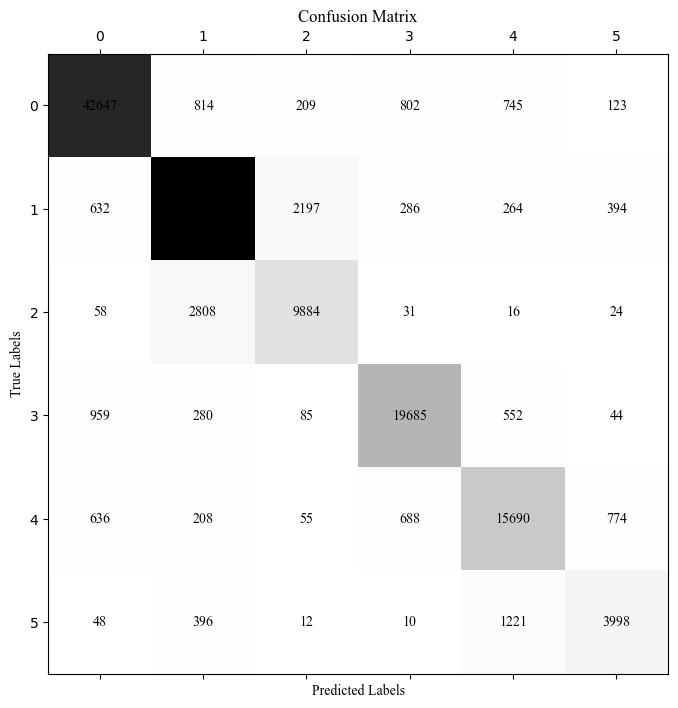

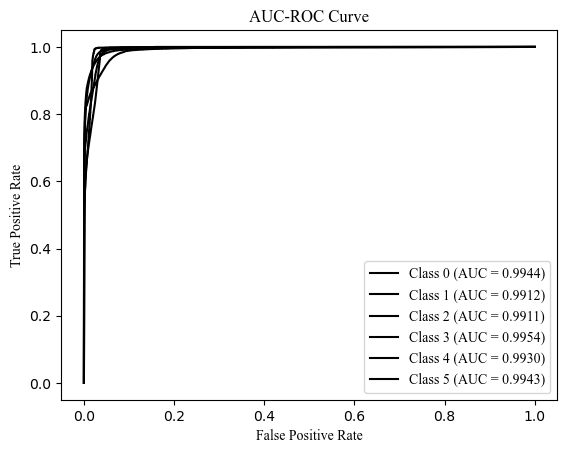

['tfidf_vectorizer.pkl']

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from tqdm import tqdm
import joblib
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

data = pd.read_csv('datasetofsenti.csv')
data = data.drop(columns=["Unnamed: 0"], errors="ignore")

train_texts, test_texts, train_labels, test_labels = train_test_split(
    data["text"], data["label"], test_size=0.375, random_state=42
)

vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words="english")
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

svm_model = SVC(kernel="linear", C=1.0, probability=True, random_state=42)

start_time = time.time()
for i in tqdm(range(1), desc="Training the SVM model"):
    svm_model.fit(X_train, train_labels)
end_time = time.time()

predictions = svm_model.predict(X_test)
predicted_probs = svm_model.predict_proba(X_test)

accuracy = accuracy_score(test_labels, predictions)
print(f"Accuracy on the Test Set: {accuracy * 100:.2f}%")
print(f"Training and Evaluation Time: {end_time - start_time:.2f} seconds")

print("\nClassification Report:")
print(classification_report(test_labels, predictions))
conf_matrix = confusion_matrix(test_labels, predictions)
plt.figure(figsize=(8, 8))
plt.matshow(conf_matrix, cmap="Greys", fignum=1)  # No color, grayscale
plt.title('Confusion Matrix', fontname='Times New Roman')
plt.xlabel('Predicted Labels', fontname='Times New Roman')
plt.ylabel('True Labels', fontname='Times New Roman')
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        plt.text(j, i, str(conf_matrix[i, j]), va='center', ha='center', fontname='Times New Roman')
plt.show()

n_classes = len(np.unique(test_labels))
test_labels_bin = label_binarize(test_labels, classes=np.unique(test_labels))

fpr = {}
tpr = {}
roc_auc = {}

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(test_labels_bin[:, i], predicted_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], linestyle='-', label=f'Class {i} (AUC = {roc_auc[i]:.4f})', color='black')

plt.title('AUC-ROC Curve', fontname='Times New Roman')
plt.xlabel('False Positive Rate', fontname='Times New Roman')
plt.ylabel('True Positive Rate', fontname='Times New Roman')
plt.legend(prop={'family': 'Times New Roman'})
plt.show()

joblib.dump(svm_model, 'svm_sentiment_model.pkl')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')
